<a href="https://colab.research.google.com/github/neurobiologylab-umass/dlc-based-behavioral-analysis/blob/main/behavioral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLC-based Behavioral Analysis

This repository contains code for analyzing the behavior of a mouse running on a rod using DeepLabCut (DLC) labeled data.

## Analysis

The analysis consists of the following steps:

1. Load the DLC labeled data to obtain the coordinates of the rods and the mouse's paws in all frames.
2. Determine whether the mouse is running on a rod, slipping off a rod, or falling off a rod.

## Settings

To use this code, you will need to adjust the following settings:

1. Change the `directory_path` and `file_name` variables to match the Google Drive you mounted and the name of the data file of the DLC labeled data.
2. Adjust the `threshold_slip` and `threshold_miss` variables to fine-tune the detection of whether the mouse is running on a rod, slipping off a rod, or falling off a rod.

In [62]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from google.colab import drive


#### Mount the Google Drive folder containing the data.

In [63]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Settings and Utility Functions

In [64]:
directory_path = "./drive/MyDrive/Data/"
file_name = "CollectedData_ife.csv"
threshold_slip = -2
threshold_miss = -40

#figure setting
linewidth = 3
def getRodLine(dataframe):
  '''
  Select columns that start with 'rod' and then get the even-numbered 
  and odd-numbered columns for the x and y coordinates respectively.
  '''
  x = df.loc[:, df.columns.str.startswith('rod')].iloc[:, ::2].values.reshape(-1, 1)
  y = df.loc[:, df.columns.str.startswith('rod')].iloc[:, 1::2].values.reshape(-1, 1)
  
  # Fit a linear model to x and y to obtain a straight line of the rod.
  model = LinearRegression()
  model.fit(x,y)
  return model
  
def getStatus(x, y, linear_model):
  slope = linear_model.coef_[0]
  intercept = linear_model.intercept_
  y_on_line = slope*x + intercept
  distance = (y - y_on_line)[0]
  if  distance<= threshold_slip:
    if distance >= threshold_miss:
      return (distance, "slip")
    else:
      return (distance, "miss")
  else:
      return (distance, "good")

def count_slip_miss(paw_stat):
  # number of slip and miss
  prev_v, count_slip, count_miss = "good", 0, 0
  total = len(paw_stat)
  for v in paw_stat.values:
    if v == "slip" and prev_v == "good":
      count_slip +=1
    elif v == "miss":
      if prev_v == "slip":
        count_miss +=1
      elif prev_v == "good":
        count_slip +=1
        count_miss +=1
  return count_slip, count_miss, round((count_slip/total) * 100,3), round((count_miss/total) * 100,3)

def behavior_plot(df):
  paw_stat_count = {"paw":[], "num_slip":[], "num_miss":[], "prec_slip":[], "prec_miss":[]}
  for paw in ["front_left", "front_right", "back_left", "back_right"]:
    paw_stat_count["paw"].append(paw)
    count_slip, count_miss, percent_slip, percent_miss = count_slip_miss(df_behavior[paw+".stat"])
    paw_stat_count["num_slip"].append(count_slip)
    paw_stat_count["num_miss"].append(count_miss)
    paw_stat_count["prec_slip"].append(f"{percent_slip} %")
    paw_stat_count["prec_miss"].append(f"{percent_miss} %")
  df_stat_count = pd.DataFrame(paw_stat_count)
  display(df_stat_count)
  fig, ax = plt.subplots(figsize=(25,4))
  sns.lineplot(x=df.index, y='front_left.dist', data=df, ax=ax, label='front_left', linewidth = linewidth, color = "#4B6D9A")
  sns.lineplot(x=df.index, y='front_right.dist', data=df, ax=ax, label='front_right', linewidth = linewidth, color = "#2A4B7C")
  sns.lineplot(x=df.index, y='back_left.dist', data=df, ax=ax, label='back_left', linewidth = linewidth, color = "#66c2a5")
  sns.lineplot(x=df.index, y='back_right.dist', data=df, ax=ax, label='back_right', linewidth = linewidth, color = "#2E8540")
  ax.set_title(f'Tracking the Behavior of a Mouse: Time Series Analysis')
  ax.set_xlabel('Frames')
  ax.set_ylabel('Distance between paw and rod line')
  ax.legend()
  ax.axhline(y=threshold_slip, color='#FF5733', linewidth = linewidth, linestyle='--')
  ax.axhline(y=threshold_miss, color='#C70039', linewidth = linewidth, linestyle='--')
  plt.show()

#### Load data & Data preprocessing




In [65]:
file_path = os.path.join(directory_path, file_name)
if file_name.endswith('.xlsx'):
  data_file = pd.ExcelFile(file_path)
  df = pd.read_excel(data_file, header=1).dropna().iloc[:,3:].astype(float).reset_index(drop=True)
else:
  df = pd.read_csv(file_path, header=1).dropna().iloc[:,3:].astype(float).reset_index(drop=True)
df.head(n=5)

,frontpawleft,frontpawleft.1,frontpawright,frontpawright.1,backpawleft,backpawleft.1,backpawright,backpawright.1,rodone,rodone.1,rodtwo,rodtwo.1,rodthree,rodthree.1
0,785.731454,669.100000,832.734421,641.325519,1289.945104,720.375964,1270.716617,671.236499,1112.615727,716.102967,777.185460,720.375964,399.025223,720.375964
1,826.324926,679.782493,625.494065,602.868546,798.550445,583.640059,779.321958,662.690504,1093.387240,720.375964,777.185460,724.648961,413.980712,720.375964
2,614.811573,679.782493,428.936202,660.554006,625.494065,598.595549,826.324926,675.509496,811.369436,722.512463,484.485163,718.239466,146.918398,713.966469
3,245.197329,630.643027,540.034125,664.827003,978.016320,688.328487,807.096439,602.868546,1025.019288,703.283976,678.906528,709.693472,356.295252,713.966469
4,745.137982,701.147478,610.538576,658.417507,798.550445,652.008012,1020.746291,684.055490,1129.707715,703.283976,785.731454,705.420475,431.072700,711.829970


#### Calculate the distance between each paw and the rod line.

In [66]:
linear_model_rod = getRodLine(df)
col_distances_status = ['front_left.dist','front_left.stat','front_right.dist','front_right.stat','back_left.dist','back_left.stat','back_right.dist','back_right.stat']
df[col_distances_status] = 0
df[["front_left.dist",'front_left.stat']] = df.apply(lambda row: getStatus(row["frontpawleft"], row["frontpawleft.1"], linear_model_rod), axis=1, result_type='expand')
df[["front_right.dist",'front_right.stat']] = df.apply(lambda row: getStatus(row["frontpawright"], row["frontpawright.1"], linear_model_rod), axis=1, result_type='expand')
df[["back_left.dist",'back_left.stat']] = df.apply(lambda row: getStatus(row["backpawleft"], row["backpawleft.1"], linear_model_rod), axis=1, result_type='expand')
df[["back_right.dist",'back_right.stat']] = df.apply(lambda row: getStatus(row["backpawright"], row["backpawright.1"], linear_model_rod), axis=1, result_type='expand')
df_behavior = df.loc[:,col_distances_status]
display(df_behavior)




,front_left.dist,front_left.stat,front_right.dist,front_right.stat,back_left.dist,back_left.stat,back_right.dist,back_right.stat
0,-2.285105,slip,-28.324613,slip,67.602387,good,17.753159,good
1,9.895773,good,-74.431239,miss,-87.271871,miss,-8.931188,slip
2,2.088395,good,-24.001120,slip,-78.704236,miss,5.622776,good
3,-60.694266,miss,-15.627278,slip,24.040998,good,-67.727935,miss
4,28.263987,good,-19.434314,slip,-18.903919,slip,21.345249,good
...,...,...,...,...,...,...,...,...
105,-14.525694,slip,-29.209504,slip,-75.938330,miss,-19.107327,slip
106,-77.913155,miss,-35.102502,slip,-22.453245,slip,-33.402761,slip
107,-24.411781,slip,-28.551107,slip,-19.355629,slip,-27.207530,slip
108,-25.960589,slip,-21.378956,slip,-20.370191,slip,-28.756338,slip


#### Plots

,paw,num_slip,num_miss,prec_slip,prec_miss
0,front_left,95,50,86.364 %,45.455 %
1,front_right,107,62,97.273 %,56.364 %
2,back_left,90,48,81.818 %,43.636 %
3,back_right,96,50,87.273 %,45.455 %


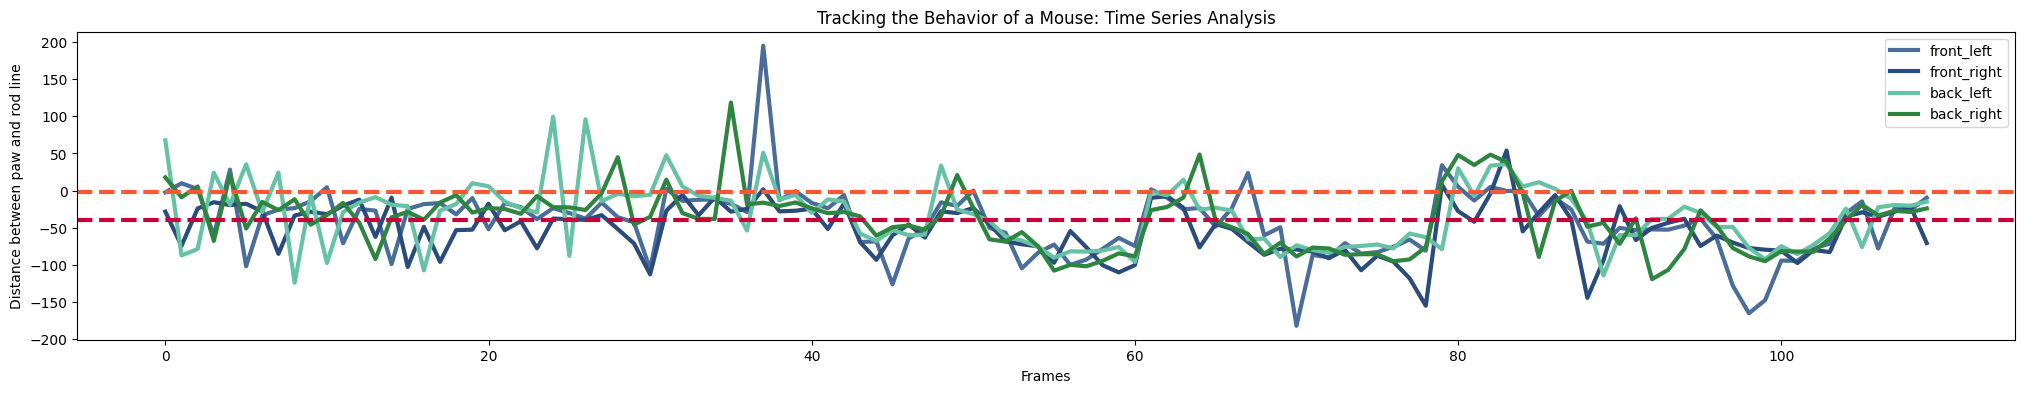

In [67]:
behavior_plot(df_behavior)